# Plongement lexical et word embeddings

Ce notebook illustre la technique du "plongement lexical", c'est-√†-dire l'apprentissage et la manipulation de repr√©sentations vectorielles du texte.

Pour cela, nous nous appuyons sur la technique la plus simple (word2vec) qui permet d'apprendre √† associer des mots √† des vecteurs (appel√©s **embeddings**) dans un espace s√©mantique abstrait.

## Plan du notebook

1. Entra√Ænement du mod√®le word2vec (d√©coupage des textes en phrases puis en mots, puis apprentissage des repr√©sentations vectorielles √† partir de notre corpus.)
3. Application 1: similarit√© s√©mantique et analogies
4. Application 2: divergences masculin/f√©minin
5. Application 3: extraction de clusters et repr√©sentations visuelles

# 1. Entra√Ænement du mod√®le word2vec

word2vec "apprend" une repr√©sentation vectorielle (spatiale) des mots d'un corpus en entra√Ænant un mod√®le √† accomplir une t√¢che de pr√©diction. Ici, la t√¢che est de pr√©dire les mots entourant un mot donn√©; par exemple, dans l'expression:

"*climate change simulation*"

Le mot doit apprendre √† pr√©dire les mots pr√©c√©dant et suivant "change":

![](output/word2vec_skipgram.png "")

C'est en apprenant √† effectuer cette t√¢che que le mod√®le apprend simultan√©ment des repr√©sentations vectorielles du vocabulaire, qui correspondent en fait √† certaines couches internes de l'architecture du r√©seau de neurones sous-jacent.


Avant tout, commen√ßons par charger les biblioth√®ques n√©cessaires :

In [73]:
import nltk
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

## Tokenization et extraction des mots

Lors de la s√©ance pr√©c√©dente, nous avons vu qu'une √©tape pr√©liminaire du traitement automatique des textes √©tait la tokenization, c'est-√†-dire le "d√©coupage" des textes en sous-unit√©s linguistiques (par exemple, en phrases, ou en mots).

Ici, nous allons d√©couper chaque titre et r√©sum√© d'article en une liste de phrases. Chaque √©l√©ment de cette liste sera lui-m√™me une liste des mots contenus dans chacune des phrases.

In [74]:
# Initialisation du lemmatizer, qui r√©duit les mots √† leur racine.

lemmatizer = nltk.stem.WordNetLemmatizer()

# Fonction de d√©coupage d'un texte en liste de listes
def text_to_sentences(text):
    # passage du texte en minuscules
    text = text.lower()

    # d√©coupage du texte en liste de phrases
    input_sentences = nltk.tokenize.sent_tokenize(text)

    # initialisation de la liste de listes
    list_of_lists = []

    # tokenization et lemmatization des mots de chaque phrase, une par une
    for sentence in input_sentences:
        # La phrase est convertie en une liste de mots, r√©duits √† leur racine
        # (La fonction tokenize_and_lemmatize est d√©finie plus bas)
        words = tokenize_and_lemmatize(sentence)
        list_of_lists.append(words)
    
    return list_of_lists

# fonction de d√©coupage des phrases en liste de mots
def tokenize_and_lemmatize(sentence):
    # d√©coupage de la phrase en liste de mots
    tokens = nltk.tokenize.word_tokenize(sentence)

    # suppression des mots qui ne contiennent pas uniquement des lettres
    tokens = [t for t in tokens if t.isalpha()]

    # part-of-speech tagging de chaque mot, pour d√©terminer leur cat√©gorie lexicale
    # (noms, adjectifs, etc.)
    tags = nltk.pos_tag(tokens)

    # On souhaite lemmatizer les mots (r√©duire √† leur forme non conjugu√©e-non accord√©e)
    # Ce dictionnaire permet d'adapter la lemmatization selon la cat√©gorie lexicale
    # Par exemple, pour un verbe, la lemmatization consiste √† passer √† l'infinitif.
    pos_lemma = {
        "J": "a",
        "N": "n",
        "V": "v"
    }

    # Pour chaque mot de la liste, 
    # On retient les mots qui sont des noms, des adjectifs, ou des verbes
    # Et on les lemmatize
    tokens = [
        lemmatizer.lemmatize(word, pos_lemma[pos[0]])
        for word, pos in tags
        if (pos[:2] == "NN" or pos[:2] == "JJ" or pos[:2] == "VB")
    ]
    
    return tokens

On peut tester la fonction :

In [75]:
text_to_sentences("This is a text. It contains multiple sentences.")

[['be', 'text'], ['contain', 'multiple', 'sentence']]

## Chargement des donn√©es

In [76]:
# chargement des articles
df = pd.read_parquet("science/climate/articles.parquet")

# chargement des abstracts (r√©sum√©s des articles)
abstracts = pd.read_parquet("science/climate/abstracts.parquet")

# ajout des abstracts au dataframe des articles
df = df.merge(abstracts, how="inner", left_index=True, right_index=True)

 # retrait des articles de titre ou r√©sum√© inconnu/vide
df.dropna(subset=["title", "abstract"], inplace=True)

## D√©coupage du corpus en liste de phrases

On peut enfin appliquer notre "pipeline" de tokenization √† l'ensemble du corpus,
ce qui fournira les donn√©es n√©cessaires √† l'entra√Ænement du mod√®le.

**Attention!** Cette √©tape prend une quinzaine de minutes sur un ordinateur performant.

In [ ]:
sentences = []
for article in tqdm(df.to_dict(orient="records"), desc="Processing articles"):
    text = article["title"] + ". " + article["abstract"]
    sentences += text_to_sentences(text)

C'est termin√©! On peut inspecter une phrase au hasard:

In [ ]:
sentences[10]

## Entra√Ænement du mod√®le word2vec

Nous utilisons l'impl√©mentation propos√©e dans la biblioth√®que Gensim.
On instancie d'abord un objet Word2Vec:

In [ ]:
model = Word2Vec(
    sentences=sentences, # La liste de phrases, chaque √©l√©ment de la liste √©tant lui-m√™me une liste de mots
    vector_size=64,   # Nombre de dimensions des vecteurs dans l'espace s√©mantique (embeddings)
    window=3,         # Taille de la fen√™tre de contexte
    min_count=5,      # Fr√©quence minimale des mots inclus
    workers=4,        # Nombre de coeurs de processeur utilis√©s pour l'entra√Ænement
    sg=1,             # Mod√®le "skip-gram" (pour lequel la t√¢che est de pr√©dire le contexte entourant chaque mot)
    epochs=1          # Nombre d'it√©rations d'entra√Ænement: 1 pour commencer
)

On effectue ensuite un certain nombre d'√©tapes d'apprentissage ("epochs"),
en affichant, √† chaque fois, les mots les plus similaires √† 3 mots cibles,
afin d'√©valuer qualitativement la coh√©rence du mod√®le √† chaque √©tape de de son entra√Ænement.

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train(sentences, total_examples=len(sentences), epochs=1)
    target_words = ["cloud", "pricing", "bayesian"]
    for word in target_words:
        if word in model.wv:
            similar = model.wv.most_similar(word, topn=5)
            print(f"üîπ {word}: " + ", ".join(f"{w} ({s:.2f})" for w, s in similar))
        else:
            print(f"‚ùå {word} not in vocabulary.")

On peut enregistrer le mod√®le pour le r√©utiliser plus tard:

In [ ]:
# model.save("output/word2vec.model")

In [ ]:
# Chargement d'un mod√®le pr√©-entra√Æn√©
model = Word2Vec.load("output/word2vec.model")

Pour acc√©der au vecteur associ√©s √† un mot, il suffit d'acc√©der √† l'attribut `wv` du mod√®le :

In [ ]:
model.wv["climate"]

# 2. Similarit√© s√©mantique et analogies

## 2.a. Similarit√© s√©mantique

Les repr√©sentations vectorielles nous permettent d'identifier des relations de proximit√© s√©mantique √† partir des distances entre les vecteurs associ√©s √† chaque mot du vocabulaire. Par exemple, pour identifier les mots les plus similaires √† "climat", il suffit de calculer la distance entre les vecteurs de chaque mot du corpus et de filtrer les plus proches. Gensim permet d'effectuer cette t√¢che facilement. Par exemple, pour observer les 10 mots les plus similaires √† "deforestation":

In [ ]:
model.wv.most_similar("deforestation", topn=10)

## 2.b. Analogies

Les analogies d√©notent des relations du type, "les rois sont aux hommes ce que les reines sont aux femmes", parfois not√©es:

$\text{king}:\text{man}::\text{queen}:\text{woman}$

Les repr√©sentations vectorielles des mots apprise par la m√©thode pr√©c√©dente permettent de recouvrir des analogies, qui se traduisent par des √©quations vectorielles dans l'espace vectoriel s√©mantique. Par exemple :

$\vec{\text{king}}+\vec{\text{woman}}-\vec{\text{man}}\simeq\vec{\text{queen}}$

![](output/analogies.png "")

Afin d'illustrer la capacit√© des embeddings √† identifier des analogies, consid√©rons le cas des vuln√©rabilit√©s r√©gionales au changement climatique. Toutes les r√©gions, en effet, ne subiront pas le m√™me genre de cons√©quences: si la californie est vuln√©rable aux incendies, qu'en est-il du Bangladesh? R√©pondre √† cette question consiste √† identifier le concept manquant dans cette analogie :

$\text{wildfire}:\text{california}::\text{?}:\text{bangladesh}$

Ce qui revient √† identifier les concepts les plus similaires au vecteur suivant :

$\vec{\text{wildfire}}+\vec{\text{bangladesh}}-\vec{\text{california}}\simeq \vec{?}$

Cela peut-√™tre fait facilement avec gensim :

In [ ]:
model.wv.most_similar(
    positive=["bangladesh", "wildfires"],
    negative=["california"]
)

On constate alors l'apparition des concepts "flood" et "riverbank", qui sugg√®re que le Bangladesh est plus vuln√©rable aux inondations et aux crues.

# 3. Divergence masculin/f√©minin

Dans cette partie, on propose d'exploiter ces repr√©sentations vectorielles afin de mieux comprendre la divergence entre les publications majoritairement masculines et majoritairement f√©minines.

Pour cela, nous proc√©dons en plusieurs √©tapes:

1. Extraction des mots contenus dans les titres de chaque article
2. Calcul de la proportion d'auteurs de genre f√©minin et masculin dans chaque article
3. √Ä partir des mots contenus dans les titres de chaque article, construction d'un vecteur s√©mantique moyen associ√© √† chaque article, en moyennant les embeddings de chacun des mots contenus dans leur titre.
4. Calcul du vecteur s√©mantique moyen des articles 1) majoritairement masculins ($\vec{m}$) et 2) majoritairement f√©minins ($\vec{f}$)
5. R√©cup√©ration des mots les plus similaires au vecteur $\vec{f}-\vec{m}$


In [ ]:
# R√©cup√©ration des mots de chaque titre
df["title_words"] = df["title"].map(text_to_sentences)

# text_to_sentences() retourne une liste de phrases, chaque phrase √©tant elle-m√™me une liste de mots;
# mais nous souhaitons une liste liste de mots.
# Par ailleurs, on exclue les mots pour lesquels la repr√©sentation vectorielle n'est pas disponible dans le mod√®le
df["title_words"] = df["title_words"].map(lambda sentences: [
    word
    for sentence in sentences
    for word in sentence
    if word in model.wv
])

# Exclusion des articles contenants peu de mots
df = df[df["title_words"].map(len) >= 2]

Ensuite, on calcule la proportion d'hommes et de femmes dans chaque article :

In [ ]:
authors = pd.read_parquet("science/climate/authors.parquet")
articles_authors = pd.read_parquet("science/climate/articles_authors.parquet")
articles_authors = articles_authors.merge(authors, left_on="author_id", right_index=True)
article_gender = articles_authors.groupby("article_id").agg(
    male = ("gender", lambda g: np.sum(g=="m")),
    female = ("gender", lambda g: np.sum(g=="f"))
)
df = df.merge(article_gender, how="inner", left_index=True, right_index=True)

On calcule un vecteur s√©mantique moyen associ√© √† chaque article :

In [ ]:
# On d√©finit une fonction transformant une liste de mots en une liste de vecteurs normalis√©s
# (c'est-√†-dire redimensionn√©s de sorte que leur longueur soit √©gale √† 1, ce qui permet de mieux les comparer)

def words_to_embeddings(words):
    return [
        normalize(model.wv[word])
        for word in words
        if word in model.wv
   ]

# Cela n√©cessite de d√©finir une fonction normalisant un vecteur pour que sa longueur soit √©gale √† 1
def normalize(v):
    return v/np.linalg.norm(v)

# On ajoute une colonne embeddings au dataframe, qui contient la liste des embeddings de chaque mot des titres des articles
df["embeddings"] = df["title_words"].map(words_to_embeddings)

# Pour moyenner les embeddings de chaque mot, article par article, on d√©finit la fonction suivante:
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

# Cela nous donne l'embedding moyen de chaque titre :
df["average_embedding"] = df["embeddings"].map(average_embedding)

In [ ]:
# On s√©pare les articles majoritairement masculins des articles majoritairement f√©minins:

male_docs = df[df["male"]>df["female"]]
female_docs = df[df["male"]<df["female"]]

# On calcul leur embedding moyen:
average_male = np.mean(np.stack(male_docs["average_embedding"].values), axis=0)
average_female = np.mean(np.stack(female_docs["average_embedding"].values), axis=0)

# On observe les mots les plus similaires √† la diff√©rence entre ces deux vecteurs:
model.wv.similar_by_vector(+(normalize(average_female)-normalize(average_male)), topn=20)

# 4. Repr√©sentation visuelle et extraction de clusters.

Les repr√©sentations vectorielles situent chaque mot dans un "espace" s√©mantique.
Cet espace peut √™tre repr√©sent√© sur une carte, offrant une repr√©sentation visuelle de la composition d'un corpus.

Lorsque des groupes de mots "proches" les uns des autres
apparaissent dans cet espace sous la forme de "clusters",
cela signalle potentiellement des th√©matiques ou des sujets parmi un corpus. 
Ainsi, des m√©thodes de clustering spatialles fond√©es sur la distance entre vecteurs
peuvent √™tre employ√©es afin de d√©tecter diff√©rents sujets dans un corpus.

Pour illustrer ces possibilit√©s, on propose de r√©aliser une carte des mots du corpus, en mettant en valeur ceux qui appartiennent √† des clusters.

On commence par restreindre le vocabulaire aux 25000 mots les plus fr√©quents du corpus, pour rendre la visualisation plus lisible :


In [ ]:
# construction d'un dictionnaire contenant le nombre d'occurrences de chaque mot dans les titres des articles du corpus
document_frequency = dict()

for words in df["title_words"].tolist():
    for word in set(words):
        document_frequency[word] = document_frequency.get(word, 0)+1

# construction d'une liste contenant tous les mots du vocabulaire
vocabulary = list(document_frequency.keys())

# classement des mots du plus fr√©quent au moins fr√©quent
top_words = sorted(
    vocabulary, # liste √† trier
    key=lambda x: document_frequency[x], # crit√®re de tri
    reverse=True # ordre (descendant)
)

# On construit une liste blanche constitu√©e des 25000 mots les plus fr√©quents du vocabulaire (les 25000 premiers √©l√©ments de la liste tri√©e)
whitelist = top_words[:25000]

Les 5 premiers mots de la liste blanche sont :

In [ ]:
whitelist[:5]

On souhaite positionner les mots sur une carte.
Pour cela, on commencer par r√©cup√©rer leurs vecteurs (leurs *embeddings*):

In [ ]:
vectors = [
    model.wv[word]
    for word in whitelist
]

# Affichage du premier vecteur:
vectors[0]

Les *embeddings* de chaque mot poss√®dent 64 composantes. Il est difficile de repr√©senter un espace √† 64 dimensions!
Pour positionner les mots sur un diagramme √† deux dimensions, il faut d'abord effectuer une op√©ration de r√©duction de dimensionalit√©.

Plusieurs m√©thodes de r√©duction de dimensionalit√© existent, les plus populaires √©tant:
 - PCA (m√©thode lin√©aire bien connue des sociologues)
 - t-SNE
 - Et UMAP, la technique que nous utiliserons.

Pour plus d'information sur le fonctionnement d'UMAP:

 - [https://pair-code.github.io/understanding-umap/index.html](https://pair-code.github.io/understanding-umap/index.html) 
 - [https://pair-code.github.io/understanding-umap/supplement.html](https://pair-code.github.io/understanding-umap/supplement.html)

In [ ]:
import umap

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30, # nombre maximum de voisins pris en compte
    min_dist=0.1, # distance minimale entre les points apr√®s r√©duction de dimensionalit√©
    metric="cosine", # mesure de distance entre points
    random_state=42 # l'algorithme n'est pas d√©terministe : pour assurer des r√©sultats reproductibles, on fixe 
)
embeddings_2d = reducer.fit_transform(vectors)
embeddings_2d[0]

Les vecteurs √©tant r√©duits √† deux composantes, ils peuvent-√™tre repr√©sent√©s sous la forme d'un scatter plot √† deux dimensions.
Pour cela, on utilise la biblioth√®que matplotlib:

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))

plt.scatter(
    x = embeddings_2d[:, 0], # abscisses
    y = embeddings_2d[:, 1], # ordonn√©es
    s = 5, # taille des points
    alpha = 0.1 # opacit√© des points
)

Pour identifier des clusters dans cette carte, on peut utiliser l'algorithme [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html):

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5, # nombre de points minimal dans chaque cluster; plus ce nombre est √©lev√©, plus les clusters seront 'gros'
    metric="euclidean" # mesure de distance 
)
cluster_labels = clusterer.fit_predict(embeddings_2d)
cluster_labels[:10]

Chaque mot se voit attribuer un cluster, identifi√© par un entier, ou bien aucun cluster (-1), ce qui correspond aux "outliers", qui ne semblent pas rattach√©s √† un cluster sp√©cifique.

On peut alors re-dessiner notre carte, en indiquant les clusters par des couleurs diff√©rentes :

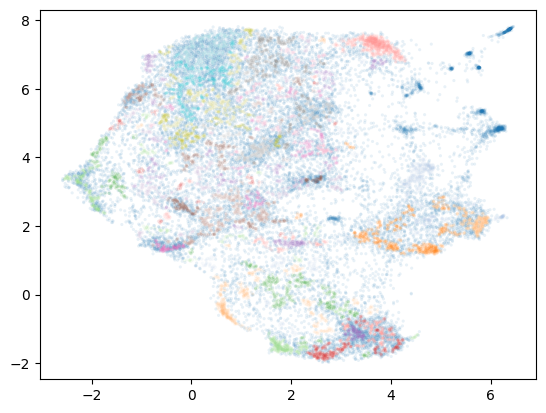

In [78]:
plt.scatter(
    x = embeddings_2d[:, 0],
    y = embeddings_2d[:, 1],
    s = 5,
    alpha = 0.1,
    c = cluster_labels,
    cmap = "tab20",
    edgecolor="none"
)

Pour comprendre cette carte, il est n√©cessaire de rattacher les points aux mots qu'ils repr√©sentent.
Pour qu'elle demeure lisible, on affiche uniquement le mot le plus fr√©quent associ√© √† chaque cluster :

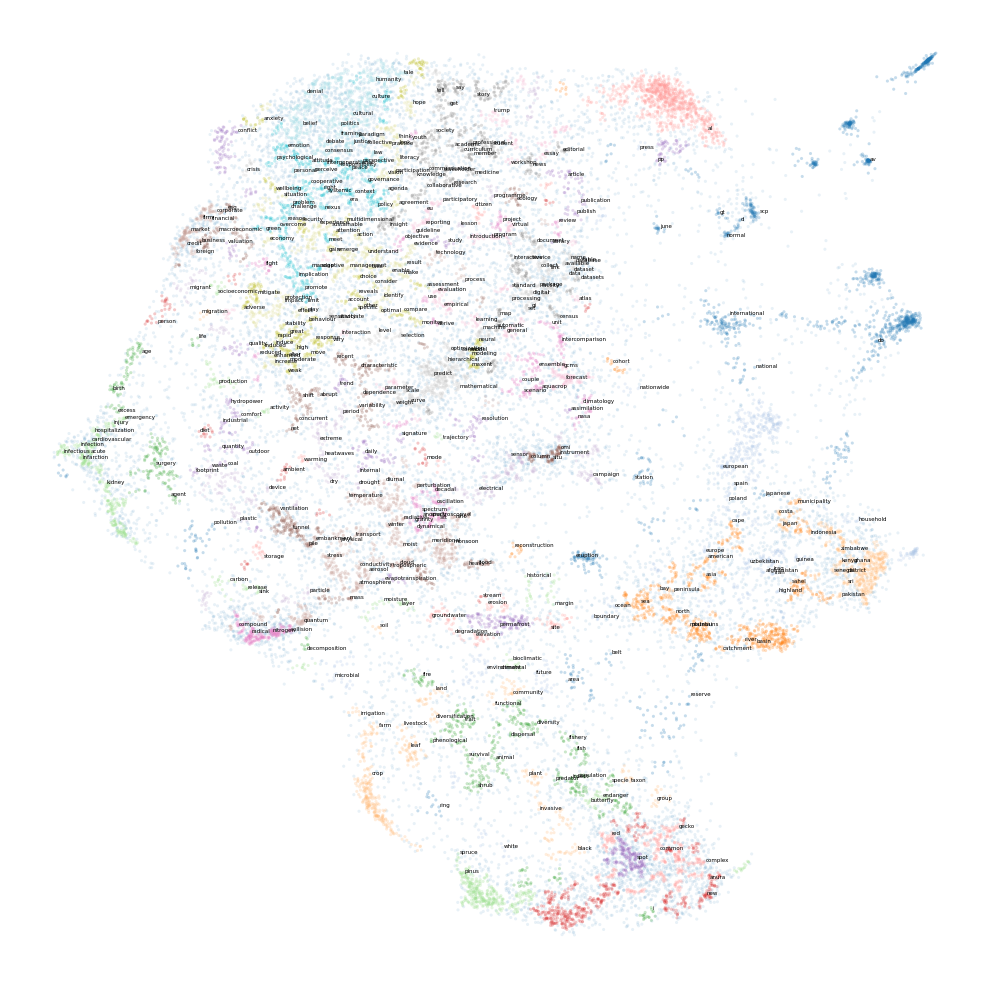

In [80]:
# Cr√©ation d'une figure
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    s=5,
    edgecolor='none',
    alpha=np.where(cluster_labels==-1, 0.1, 0.25),
    c=cluster_labels,
    cmap="tab20",
)

words = pd.DataFrame({
    "word": whitelist,
    "cluster": cluster_labels,
    "frequency": [document_frequency[x] for x in whitelist],
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
})

words.sort_values(["cluster", "frequency"], inplace=True, ascending=False)

for word in words.groupby("cluster").head(1).to_dict(orient="records"):
    if word["frequency"] < 100:
        continue
    
    plt.text(word["x"] + 0.01, word["y"] + 0.01, word["word"], fontsize=4)

plt.axis('off')
plt.tight_layout()
plt.savefig("output/map_clusters.pdf")

Une autre fa√ßon de repr√©senter la carte est d'employer des couleurs repr√©sentant la position de chaque mot sur l'axe f√©minin-masculin.
Voici une mani√®re de le faire :


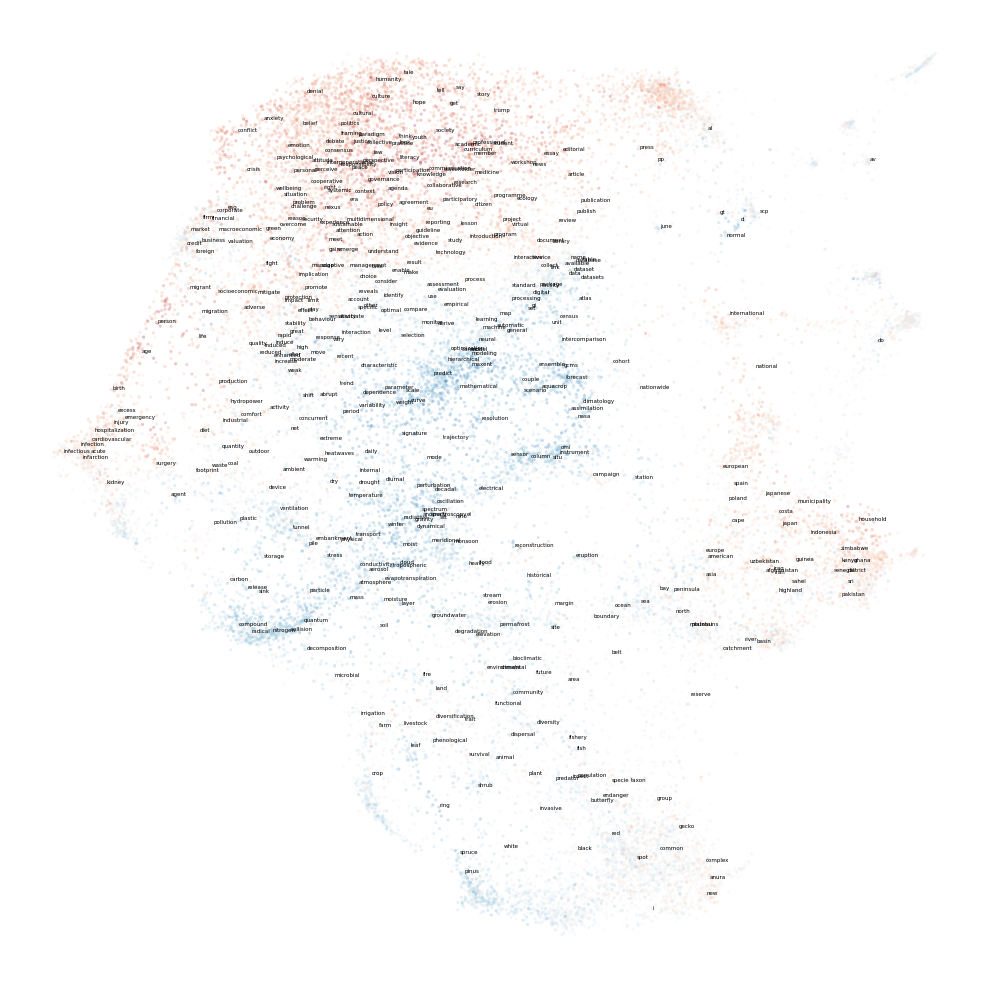

In [81]:
genders = [cosine(average_female-average_male, vector) for vector in vectors]

# Plot the result
plt.figure(figsize=(10, 10))
plt.scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    s=5,
    edgecolor='none',
    alpha=0.25,
    c=genders,
    cmap="RdBu",
    vmin=np.min(genders),
    vmax=np.max(genders)
)

words = pd.DataFrame({
    "word": whitelist,
    "cluster": cluster_labels,
    "frequency": [document_frequency[x] for x in whitelist],
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
    "gender": genders,
})

words.sort_values(["cluster", "frequency"], inplace=True, ascending=False)

for word in words.groupby("cluster").head(1).to_dict(orient="records"):
    if word["frequency"] < 100:
        continue
    
    plt.text(word["x"] + 0.01, word["y"] + 0.01, word["word"], fontsize=4)


plt.axis('off')
plt.tight_layout()
plt.savefig("output/map_gender.pdf")